## Exploring Flight Delays: A Data Modeling and Analysis Approach for Predicting Causes for Delays in Airline On-time Data

## Names

* Aditya Tomar
* Shay Samat
* Akhil Vasanth


<a id='Introduction'></a>
# Introduction

* Define the real problem and explain its motivation
Identify the dataset you will use and explain its key characteristics.
Explain at least one hypothesis that you will test.



## Methods

Identify the data analysis approach you will use and explain the rationale/motivation for your choice of this approach. Clearly state whether you are focusing on prediction or inference. Explain why the model class you have chosen is appropriate for the data and questions in your project.

We are using Logistic Regression with sigmoid function and KNN

# Results


* Model selection. You MUST compare at least 2 models, using cross-validation, regularization, and/or other relevant techniques.
* Model estimation. What are the final parameter estimates? What is the final accuracy of the model’s predictions?


# Conclusions and discussion

What can you conclude about your hypothesis? (Note that negative or ambiguous results are perfectly acceptable, you just need to explain what you found.) What are some potential implications/next steps for researchers interested in this topic?

# Rubric

Introduction and hypotheses
Introduction explaining the motivation/significance of the project. Identify and explain the dataset you will use, including clearly stating the number of observations (n) and predictors (p). Explain at least one hypothesis that you will test.

Methods - cross-validation
Explain what form of cross-validation you will use. Give a clear explanation, including any procedures you will use for randomizing the order of observations, splitting testing and training sets. It is NOT sufficient to simply reference a Python library; you must explain how the library actually performs the cross-validation.

Methods
Identify the data analysis approach you will use and explain the rationale/motivation for your choice of this approach. Clearly state whether you are focusing on prediction or inference. Explain why the model class you have chosen is appropriate for the data and questions in your project.

Results - model selection
Your results must include at least two different models or analyses of the same data, with an objective comparison/evaluation of the relative merit of the two approaches. You must use cross-validation for this model comparison. Note that the models you compare can be very similar, e.g. fitting a regression with 2 explanatory (independent) variables vs. 3 variables. Show a graph or table (as appropriate) to illustrate the objective model comparison you performed, and explain why you chose the final model. This section should discuss the complexity/flexibility of the different models. You should also discuss whether any of the models you studied showed evidence of overfitting.

Results - model estimation
What are the final parameter estimates (obtained using the full dataset)? What is the final accuracy of the model’s predictions?

Include at least one figure to visualize your results. Your figure should be fully labeled and self-explanatory, with axis labels and a figure legend.

Discussion
What can you conclude about your hypothesis? (Note that negative or ambiguous results are perfectly acceptable, you just need to explain what you found.) What are some potential implications/next steps for researchers interested in this topic?



# Preprocessing

In [20]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt


In [11]:
csv_files = []
years = [2018, 2019, 2022]
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

for year in years:
    for month in months:
        csv_file = "data/{:02d}_{}.csv".format(int(month), year)
        csv_files.append(csv_file)

dfs = []

for csv_file in csv_files:
    df = pd.read_csv(csv_file, low_memory=False)
    dfs.append(df)

flights = pd.concat(dfs, ignore_index=True)
flights.head()


,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST_CITY_NAME,DEST_STATE_ABR,DEP_DELAY_NEW,ARR_DELAY_NEW,ACTUAL_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,ORIGIN_STATE_NM,DEST_STATE_NM
0,1/1/2018 12:00:00 AM,9E,"Albany, GA",GA,"Atlanta, GA",GA,0.0,0.0,54.0,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1/1/2018 12:00:00 AM,9E,"Albany, GA",GA,"Atlanta, GA",GA,0.0,0.0,55.0,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1/1/2018 12:00:00 AM,9E,"Alexandria, LA",LA,"Atlanta, GA",GA,0.0,0.0,92.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1/1/2018 12:00:00 AM,9E,"Alexandria, LA",LA,"Atlanta, GA",GA,39.0,23.0,89.0,500.0,0.0,0.0,0.0,0.0,23.0,NaN,NaN
4,1/1/2018 12:00:00 AM,9E,"Appleton, WI",WI,"Minneapolis, MN",MN,0.0,0.0,65.0,236.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
flights = flights.drop(["ORIGIN_STATE_ABR", "DEST_STATE_ABR","ORIGIN_STATE_NM","DEST_STATE_NM"], axis=1)
flights

,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN_CITY_NAME,DEST_CITY_NAME,DEP_DELAY_NEW,ARR_DELAY_NEW,ACTUAL_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,1/1/2018 12:00:00 AM,9E,"Albany, GA","Atlanta, GA",0.0,0.0,54.0,145.0,NaN,NaN,NaN,NaN,NaN
1,1/1/2018 12:00:00 AM,9E,"Albany, GA","Atlanta, GA",0.0,0.0,55.0,145.0,NaN,NaN,NaN,NaN,NaN
2,1/1/2018 12:00:00 AM,9E,"Alexandria, LA","Atlanta, GA",0.0,0.0,92.0,500.0,NaN,NaN,NaN,NaN,NaN
3,1/1/2018 12:00:00 AM,9E,"Alexandria, LA","Atlanta, GA",39.0,23.0,89.0,500.0,0.0,0.0,0.0,0.0,23.0
4,1/1/2018 12:00:00 AM,9E,"Appleton, WI","Minneapolis, MN",0.0,0.0,65.0,236.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21357352,12/31/2022 12:00:00 AM,YX,"Washington, DC","Raleigh/Durham, NC",0.0,0.0,71.0,227.0,NaN,NaN,NaN,NaN,NaN
21357353,12/31/2022 12:00:00 AM,YX,"Wilmington, NC","New York, NY",0.0,NaN,NaN,500.0,NaN,NaN,NaN,NaN,NaN
21357354,12/31/2022 12:00:00 AM,YX,"Wilmington, NC","New York, NY",0.0,0.0,92.0,500.0,NaN,NaN,NaN,NaN,NaN
21357355,12/31/2022 12:00:00 AM,YX,"Wilmington, NC","Newark, NJ",0.0,0.0,100.0,488.0,NaN,NaN,NaN,NaN,NaN


In [13]:
delay_columns = [col for col in flights.columns if "DELAY" in col]
flights[delay_columns] = flights[delay_columns].fillna(0)

In [26]:
flights.describe()

,DEP_DELAY_NEW,ARR_DELAY_NEW,ACTUAL_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
count,2.135736e+07,2.135736e+07,2.087206e+07,2.135736e+07,2.135736e+07,2.135736e+07,2.135736e+07,2.135736e+07,2.135736e+07
mean,1.395409e+01,1.392333e+01,1.368909e+02,8.052769e+02,4.330953e+00,7.182890e-01,2.813930e+00,2.135812e-02,5.039492e+00
std,4.729044e+01,4.693918e+01,7.270466e+01,5.951796e+02,3.068529e+01,1.370043e+01,1.648249e+01,1.501947e+00,2.544449e+01
min,0.000000e+00,0.000000e+00,1.400000e+01,3.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,8.400000e+01,3.700000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,1.190000e+02,6.440000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,7.000000e+00,8.000000e+00,1.670000e+02,1.041000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,3.433000e+03,3.423000e+03,1.604000e+03,5.095000e+03,3.423000e+03,2.692000e+03,1.848000e+03,1.245000e+03,2.454000e+03


In [27]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21357357 entries, 0 to 21357356
Data columns (total 13 columns):
 #   Column               Dtype  
---  ------               -----  
 0   FL_DATE              object 
 1   OP_UNIQUE_CARRIER    object 
 2   ORIGIN_CITY_NAME     object 
 3   DEST_CITY_NAME       object 
 4   DEP_DELAY_NEW        float64
 5   ARR_DELAY_NEW        float64
 6   ACTUAL_ELAPSED_TIME  float64
 7   DISTANCE             float64
 8   CARRIER_DELAY        float64
 9   WEATHER_DELAY        float64
 10  NAS_DELAY            float64
 11  SECURITY_DELAY       float64
 12  LATE_AIRCRAFT_DELAY  float64
dtypes: float64(9), object(4)
memory usage: 2.1+ GB


In [28]:
flights

,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN_CITY_NAME,DEST_CITY_NAME,DEP_DELAY_NEW,ARR_DELAY_NEW,ACTUAL_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,1/1/2018 12:00:00 AM,9E,"Albany, GA","Atlanta, GA",0.0,0.0,54.0,145.0,0.0,0.0,0.0,0.0,0.0
1,1/1/2018 12:00:00 AM,9E,"Albany, GA","Atlanta, GA",0.0,0.0,55.0,145.0,0.0,0.0,0.0,0.0,0.0
2,1/1/2018 12:00:00 AM,9E,"Alexandria, LA","Atlanta, GA",0.0,0.0,92.0,500.0,0.0,0.0,0.0,0.0,0.0
3,1/1/2018 12:00:00 AM,9E,"Alexandria, LA","Atlanta, GA",39.0,23.0,89.0,500.0,0.0,0.0,0.0,0.0,23.0
4,1/1/2018 12:00:00 AM,9E,"Appleton, WI","Minneapolis, MN",0.0,0.0,65.0,236.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21357352,12/31/2022 12:00:00 AM,YX,"Washington, DC","Raleigh/Durham, NC",0.0,0.0,71.0,227.0,0.0,0.0,0.0,0.0,0.0
21357353,12/31/2022 12:00:00 AM,YX,"Wilmington, NC","New York, NY",0.0,0.0,NaN,500.0,0.0,0.0,0.0,0.0,0.0
21357354,12/31/2022 12:00:00 AM,YX,"Wilmington, NC","New York, NY",0.0,0.0,92.0,500.0,0.0,0.0,0.0,0.0,0.0
21357355,12/31/2022 12:00:00 AM,YX,"Wilmington, NC","Newark, NJ",0.0,0.0,100.0,488.0,0.0,0.0,0.0,0.0,0.0


# EDA

<AxesSubplot:>

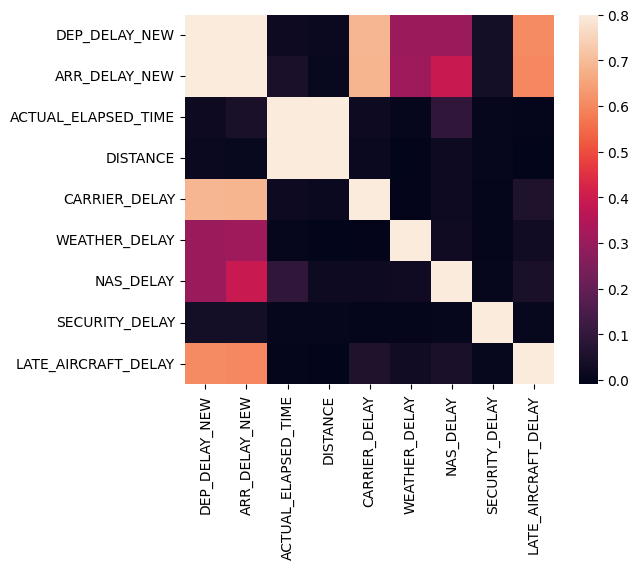

In [21]:
corrmat = flights.corr()
sns.heatmap(corrmat, vmax=.8, square=True)

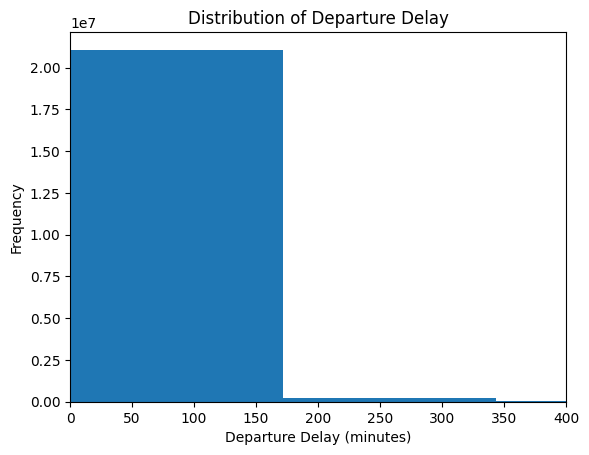

In [25]:
# Distribution of departure delay
plt.hist(flights['DEP_DELAY_NEW'], bins=20)
plt.xlim(0,400)
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Departure Delay')
plt.show()

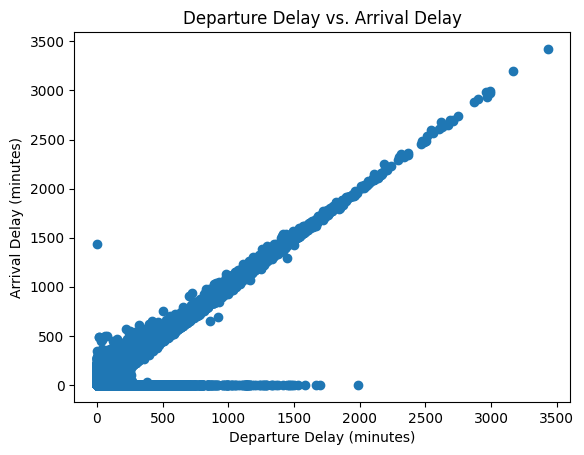

In [29]:
plt.scatter(flights['DEP_DELAY_NEW'], flights['ARR_DELAY_NEW'])
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Arrival Delay (minutes)')
plt.title('Departure Delay vs. Arrival Delay')
plt.show()

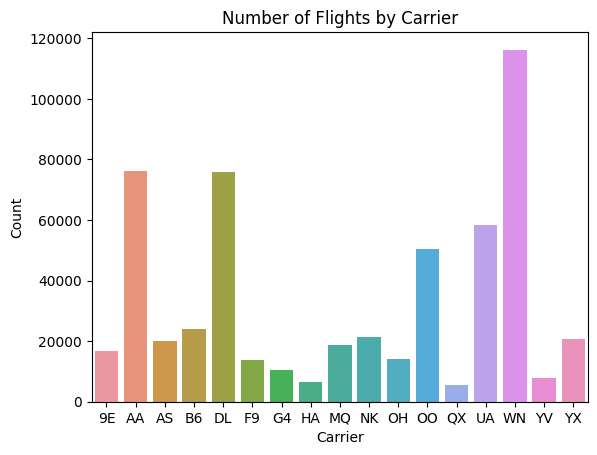

In [59]:
# Bar plot of unique carriers
sns.countplot(data=df, x='OP_UNIQUE_CARRIER')
plt.xlabel('Carrier')
plt.ylabel('Count')
plt.title('Number of Flights by Carrier')
plt.show()

In [32]:
avg_dep_delay_by_city = flights.groupby('ORIGIN_CITY_NAME')['DEP_DELAY_NEW'].mean()

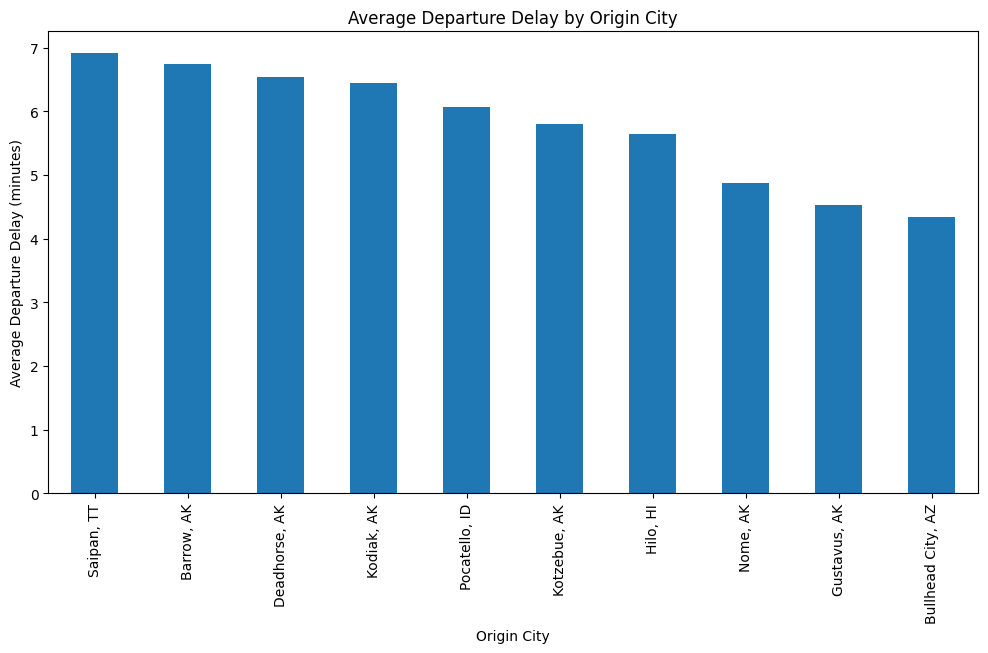

In [84]:
plt.figure(figsize=(12, 6))
avg_dep_delay_by_city.sort_values(ascending=False)[-10:].plot(kind='bar')
plt.xlabel('Origin City')
plt.ylabel('Average Departure Delay (minutes)')
plt.title('Average Departure Delay by Origin City')
plt.show()

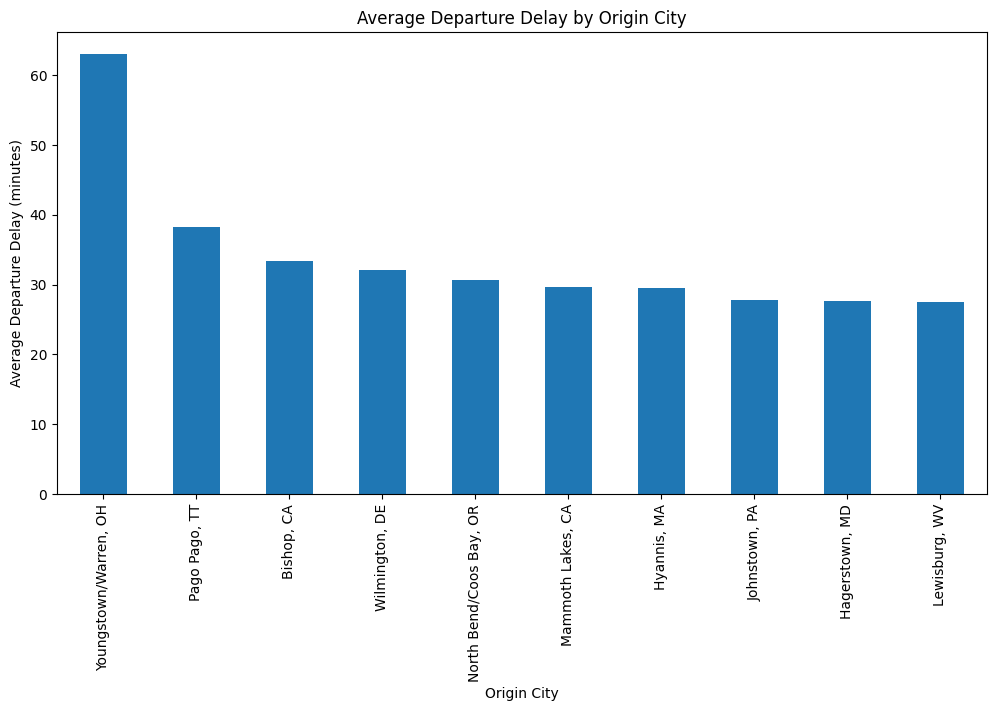

In [85]:
plt.figure(figsize=(12, 6))
avg_dep_delay_by_city.sort_values(ascending=False)[0:10].plot(kind='bar')
plt.xlabel('Origin City')
plt.ylabel('Average Departure Delay (minutes)')
plt.title('Average Departure Delay by Origin City')
plt.show()

In [50]:
flights['TOTAL_DELAY'] = flights['ARR_DELAY_NEW'] + flights['DEP_DELAY_NEW']


In [51]:
flights

,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN_CITY_NAME,DEST_CITY_NAME,DEP_DELAY_NEW,ARR_DELAY_NEW,ACTUAL_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,total_delay,TOTAL_DELAY
0,1/1/2018 12:00:00 AM,9E,"Albany, GA","Atlanta, GA",0.0,0.0,54.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1/1/2018 12:00:00 AM,9E,"Albany, GA","Atlanta, GA",0.0,0.0,55.0,145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1/1/2018 12:00:00 AM,9E,"Alexandria, LA","Atlanta, GA",0.0,0.0,92.0,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1/1/2018 12:00:00 AM,9E,"Alexandria, LA","Atlanta, GA",39.0,23.0,89.0,500.0,0.0,0.0,0.0,0.0,23.0,62.0,62.0
4,1/1/2018 12:00:00 AM,9E,"Appleton, WI","Minneapolis, MN",0.0,0.0,65.0,236.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21357352,12/31/2022 12:00:00 AM,YX,"Washington, DC","Raleigh/Durham, NC",0.0,0.0,71.0,227.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21357353,12/31/2022 12:00:00 AM,YX,"Wilmington, NC","New York, NY",0.0,0.0,NaN,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21357354,12/31/2022 12:00:00 AM,YX,"Wilmington, NC","New York, NY",0.0,0.0,92.0,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21357355,12/31/2022 12:00:00 AM,YX,"Wilmington, NC","Newark, NJ",0.0,0.0,100.0,488.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
correlation = flights[['TOTAL_DELAY', 'DISTANCE']].corr()
print(correlation)

             TOTAL_DELAY  DISTANCE
TOTAL_DELAY     1.000000  0.009457
DISTANCE        0.009457  1.000000


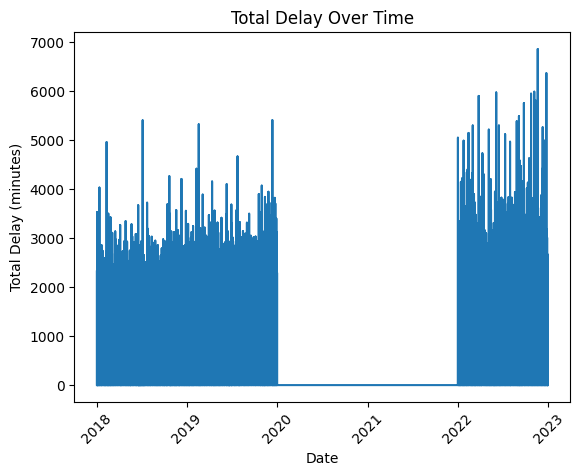

In [63]:
# Time series analysis - Total delay over time
flights['FL_DATE'] = pd.to_datetime(flights['FL_DATE'])  # Convert date to datetime format if needed

flights_filtered = flights[(flights['FL_DATE'].dt.year != 2020) & (flights['FL_DATE'].dt.year != 2021)]


plt.plot(flights_filtered['FL_DATE'], flights_filtered['TOTAL_DELAY'])
plt.xlabel('Date')
plt.ylabel('Total Delay (minutes)')
plt.title('Total Delay Over Time')
plt.xticks(rotation=45)
plt.show()


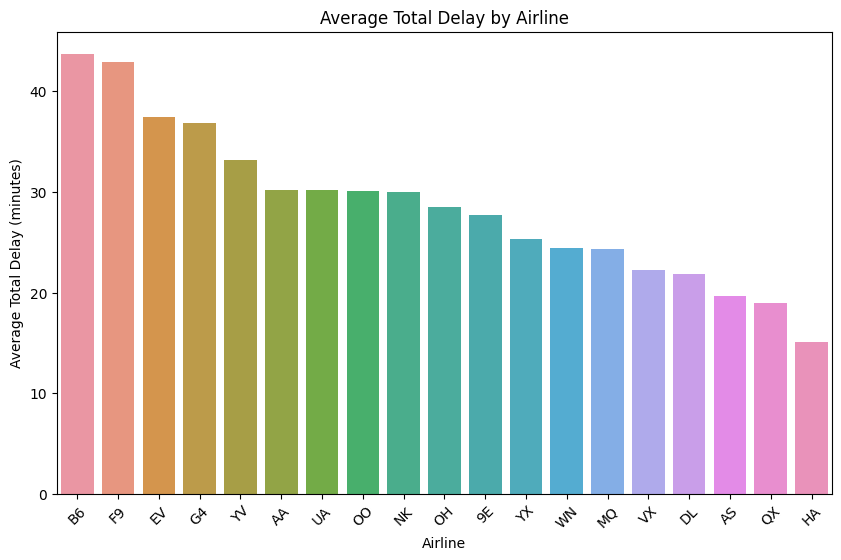

In [56]:
# Comparison analysis - Average total delay by airline
avg_delay_by_airline = flights.groupby('OP_UNIQUE_CARRIER')['TOTAL_DELAY'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_delay_by_airline.index, y=avg_delay_by_airline.values)
plt.xlabel('Airline')
plt.ylabel('Average Total Delay (minutes)')
plt.title('Average Total Delay by Airline')
plt.xticks(rotation=45)
plt.show()

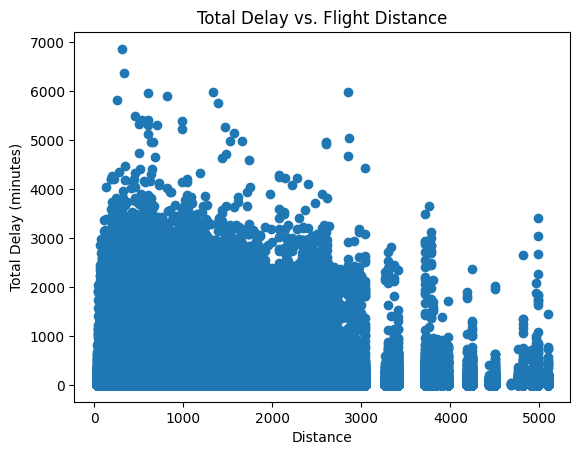

In [67]:
# Scatter plot - Delay vs. distance
plt.scatter(flights['DISTANCE'], flights['total_delay'])
plt.xlabel('Distance')
plt.ylabel('Total Delay (minutes)')
plt.title('Total Delay vs. Flight Distance')
plt.show()

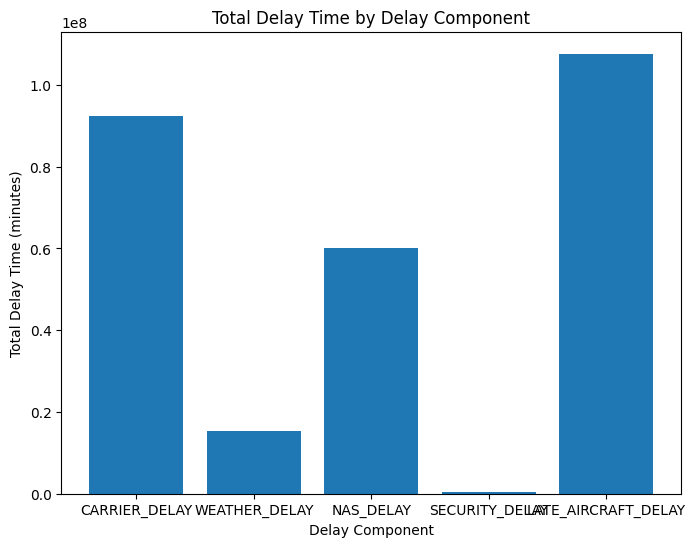

In [68]:
# Stacked bar plot - Delay components
delay_components = ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
delay_sums = flights[delay_components].sum()
plt.figure(figsize=(8, 6))
plt.bar(delay_components, delay_sums)
plt.xlabel('Delay Component')
plt.ylabel('Total Delay Time (minutes)')
plt.title('Total Delay Time by Delay Component')
plt.show()

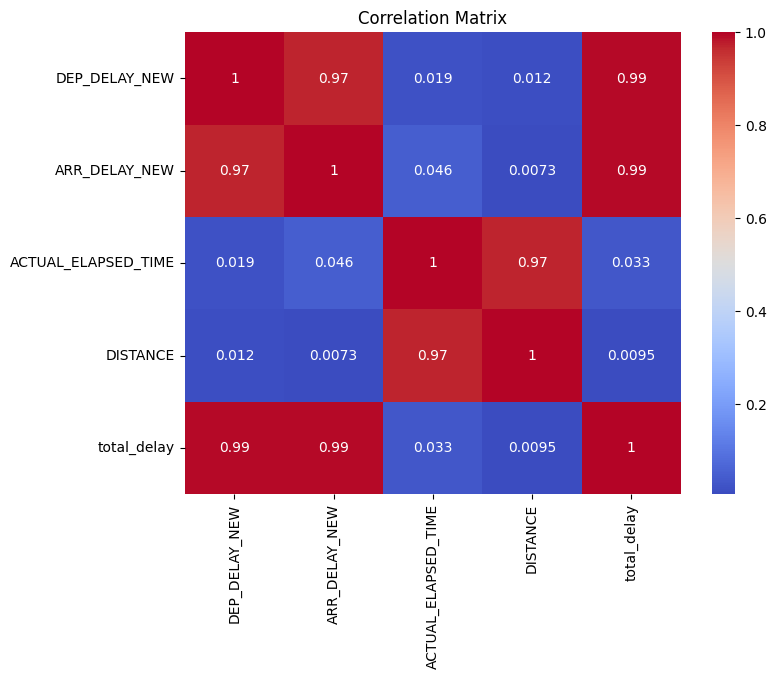

In [69]:
# Heatmap - Correlation matrix
correlation_matrix = flights[['DEP_DELAY_NEW', 'ARR_DELAY_NEW', 'ACTUAL_ELAPSED_TIME', 'DISTANCE', 'total_delay']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

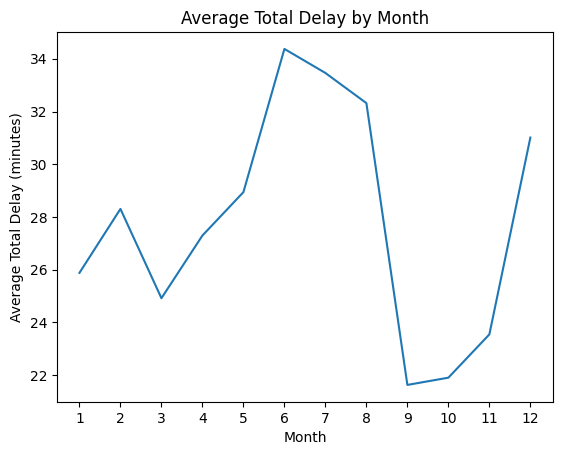

In [70]:
flights['Month'] = flights['FL_DATE'].dt.month
avg_delay_by_month = flights.groupby('Month')['total_delay'].mean()
plt.plot(avg_delay_by_month.index, avg_delay_by_month.values)
plt.xlabel('Month')
plt.ylabel('Average Total Delay (minutes)')
plt.title('Average Total Delay by Month')
plt.xticks(range(1, 13))
plt.show()